In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
import os
import time

path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"

#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


# Load dataset

In [2]:
#load in dataset as compressed numpy (for storage) 
X_=np.load(datapath+"X_sandpaper_pressip2.npz")
for array_name in X_:
    X=X_[array_name]#.astype(np.uint8)
y_=np.load(datapath+"y_sandpaper_pressip2.npz")
for array_name in y_:
    y=y_[array_name]#.astype(np.uint8)

y[y==7]=180 #put as sandpaper vaue to make clearer
y[y==4]=120
y[y==3]=80
y[y==6]=40
#convert it all to voltages
X=(X* 3.3) / 65536
#remove unneeded columns
vibration_X=X[:,:,8]
X_all=X.copy()
X=X[:,:,[i for i in range(8)]+[8,12,13,14,15]] #all data but gyro

print("Vibration X data",vibration_X.shape)
print("y data",y.shape)
print("X data (num readings, timestep, sensor channel)",X.shape)
trial_time=1719216609.4364703-1719216600.0451353
print("Time per step",trial_time/X.shape[1],"seconds")

Vibration X data (1600, 100)
y data (1600,)
X data (num readings, timestep, sensor channel) (1600, 100, 13)
Time per step 0.09391335010528565 seconds


In [280]:
#y[y==3]=180 #put as sandpaper vaue to make clearer
#y[y==5]=120
#y[y==4]=80
#y[y==7]=40
0.09391335010528565*6

0.5634801006317138

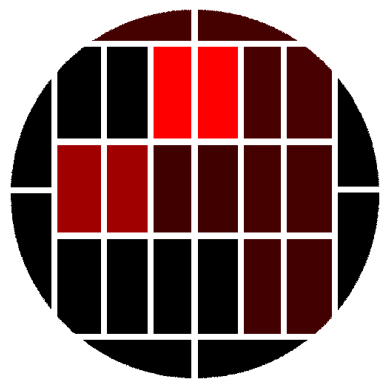

In [273]:
def visualise_pressues(channels):
    img = cv2.imread('/its/home/drs25/Pictures/pressTip/demonstrate.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dictionary={0:(0,189,230),1:(230,211,0),2:(230,0,227),3:(30,108,12),4:(230,0,0),6:(0,20,101),5:(121,36,116),6:(0,20,101),7:(229,112,112),8:(-1,-1,-1),9:(-1,-1,-1),10:(-1,-1,-1),11:(-1,-1,-1),12:(121,78,36),13:(0,45,230),14:(230,83,0),15:(112,229,122)}
    copied=np.zeros_like(img)
    mask = np.all(img == (0,0,0), axis=-1)
    copied[mask]=(255,255,255)
    for i in range(0,len(channels)):
        assert dictionary[i] in img or dictionary[i] == (-1,-1,-1), "Colour not in image:"+str(dictionary[i]) #check that the colour is in the correct format
        mask = np.all(img == dictionary[i], axis=-1)
        copied[mask]=(min(255,int(channels[i]*255)),0,0)
        #print((min(255,int(channels[i]*255)),0,0))
    mask = np.any((copied<110) & (copied>0), axis=-1)
    copied[mask,0]+=60
    copied[copied>255]=255
    copied[copied<0]=0

    return copied

plt.imshow(visualise_pressues(X_all[0][1]))
plt.axis("off")
plt.show()

# Visualise

400 400 400 400


/tmp/ipykernel_5376/2378088202.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


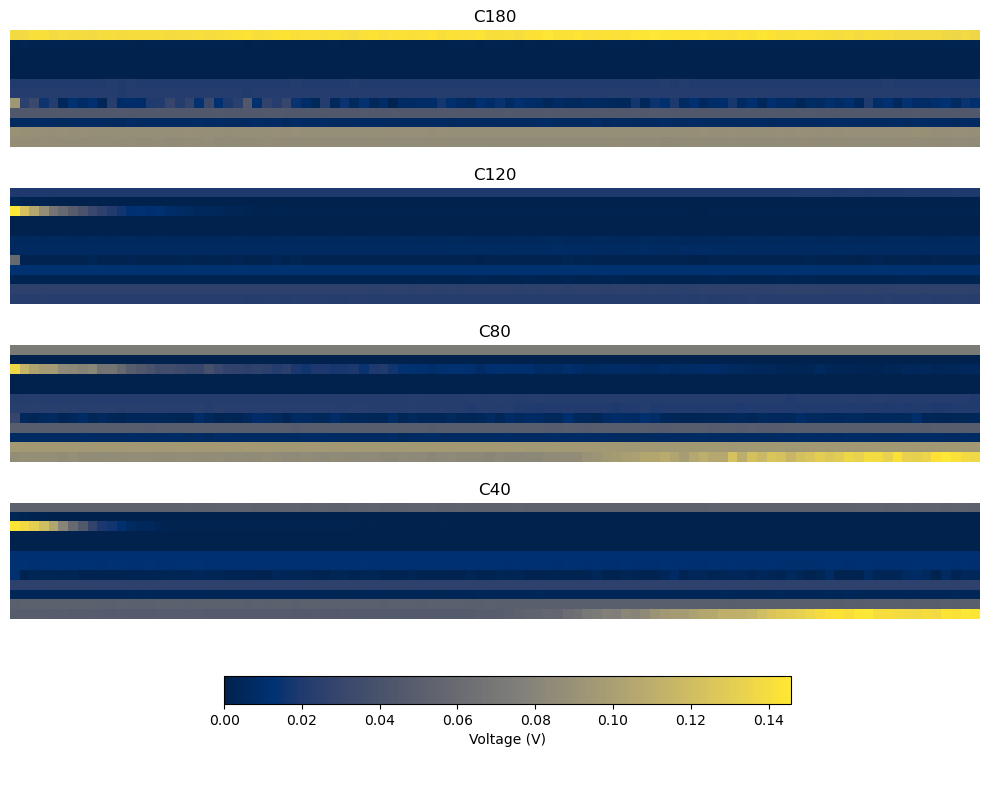

In [127]:
#split them up for vis
d120=X[np.where(y==120)]
d180=X[np.where(y==180)]
d80=X[np.where(y==80)]
d40=X[np.where(y==40)]

print(len(d120),len(d180),len(d80),len(d40))
averaged120=np.average(d120,axis=0)
averaged180=np.average(d180,axis=0)
averaged80=np.average(d80,axis=0)
averaged40=np.average(d40,axis=0)

data=[averaged180,averaged120,averaged80,averaged40]
label=["C180","C120","C80","C40"]
fig, axes = plt.subplots(5, 1, figsize=(10, 8))
axes = axes.flatten()
for i in range(len(data)):
    im=axes[i].imshow(data[i].T[1:],cmap="cividis")
    axes[i].set_title(label[i])
    axes[i].axis("off")
#axes[-1].imshow(np.zeros((1,1)))
axes[-1].axis('off')

#fig.colorbar(im,ax=axes[i],label="Voltage", orientation="horizontal") 
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.046, pad=0.1)
cbar.set_label('Voltage (V)')

plt.tight_layout()
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/allPressuresSandpaper.pdf")
plt.show()

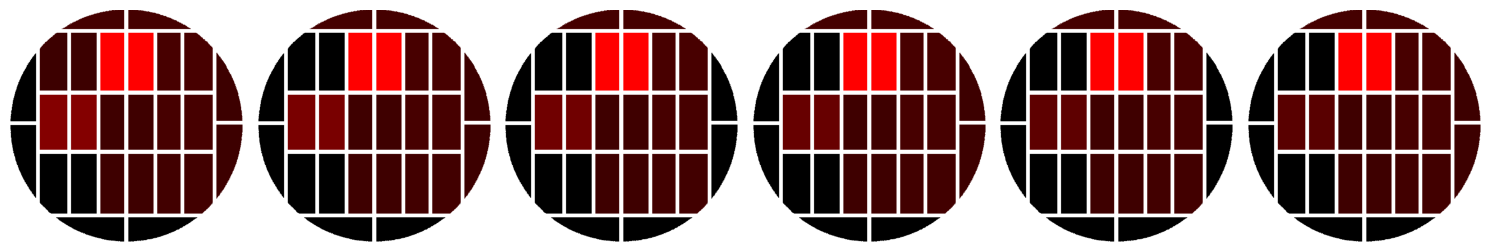

In [279]:

d120=X_all[np.where(y==120)]
d180=X_all[np.where(y==180)]
d80=X_all[np.where(y==80)]
d40=X_all[np.where(y==40)]

averaged120=np.average(d120,axis=0)
averaged180=np.average(d180,axis=0)
averaged80=np.average(d80,axis=0)
averaged40=np.average(d40,axis=0)

fig, axes = plt.subplots(1, 6, figsize=(15, 10))
axes = axes.flatten()
for i in range(6):
    im=axes[i].imshow(visualise_pressues(averaged120[i]),cmap="cividis")
    axes[i].axis("off")
plt.tight_layout()
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/actualPad.pdf", bbox_inches='tight')
plt.show()

In [86]:
averaged120*255

array([[8.03476362e+02, 9.88598145e+00, 1.70929687e+00, ...,
        1.05187500e+00, 1.29019043e+01, 1.14309229e+01],
       [8.03755767e+02, 9.90241699e+00, 8.62866211e-01, ...,
        1.00256836e+00, 1.28525977e+01, 1.14637939e+01],
       [8.03796855e+02, 9.93528809e+00, 4.35541992e-01, ...,
        9.69697266e-01, 1.28854687e+01, 1.15706250e+01],
       ...,
       [8.03706460e+02, 9.95994141e+00, 0.00000000e+00, ...,
        1.10118164e+00, 1.31977441e+01, 1.17267627e+01],
       [8.03616064e+02, 9.94350586e+00, 0.00000000e+00, ...,
        1.00256836e+00, 1.32552686e+01, 1.16856738e+01],
       [8.03788638e+02, 9.94350586e+00, 0.00000000e+00, ...,
        1.13405273e+00, 1.29429932e+01, 1.15624072e+01]])

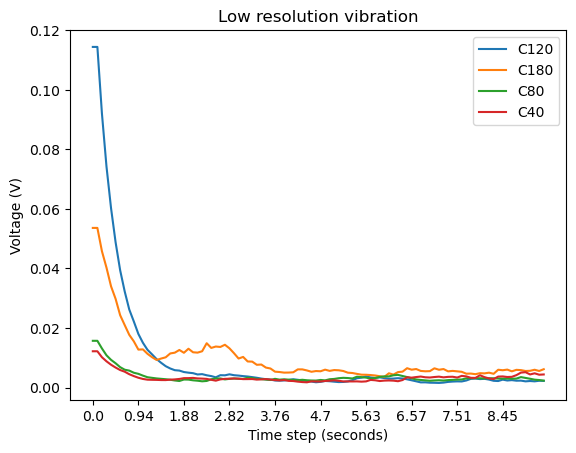

In [11]:
def low_pass_filter(data,alpha=0.8):
    y=np.zeros(data.shape)
    y[0]=data[0]
    for i in range(len(y)-1):
        y[i+1]=y[i]*alpha + (1-alpha)*data[i]
    return y

#split them up for vis
d120=vibration_X[np.where(y==120)]
d180=vibration_X[np.where(y==180)]
d80=vibration_X[np.where(y==80)]
d40=vibration_X[np.where(y==40)]

np.save("/its/home/drs25/Documents/d180",d180)
np.save("/its/home/drs25/Documents/d120",d120)
np.save("/its/home/drs25/Documents/d80",d80)
np.save("/its/home/drs25/Documents/d40",d40)


#get average of all trials
averaged120=np.average(d120,axis=0)
averaged180=np.average(d180,axis=0)
averaged80=np.average(d80,axis=0)
averaged40=np.average(d40,axis=0)

#low pass filter
sampling_rate=trial_time/X.shape[1]

filtered_averaged120 = low_pass_filter(averaged120)
filtered_averaged180 = low_pass_filter(averaged180)
filtered_averaged80 = low_pass_filter(averaged80)
filtered_averaged40 = low_pass_filter(averaged40)

plt.ylabel("Voltage (V)")
plt.xlabel("Time step (seconds)")
plt.xticks([i for i in range(0,len(averaged120),10)],[round(sampling_rate*i,2) for i in range(0,len(averaged120),10)])
plt.plot(filtered_averaged120,label="C120")
plt.plot(filtered_averaged180,label="C180")
plt.plot(filtered_averaged80,label="C80")
plt.plot(filtered_averaged40,label="C40")
plt.legend(loc="upper right")
plt.title("Low resolution vibration")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/lowResVibration.pdf")
plt.show()

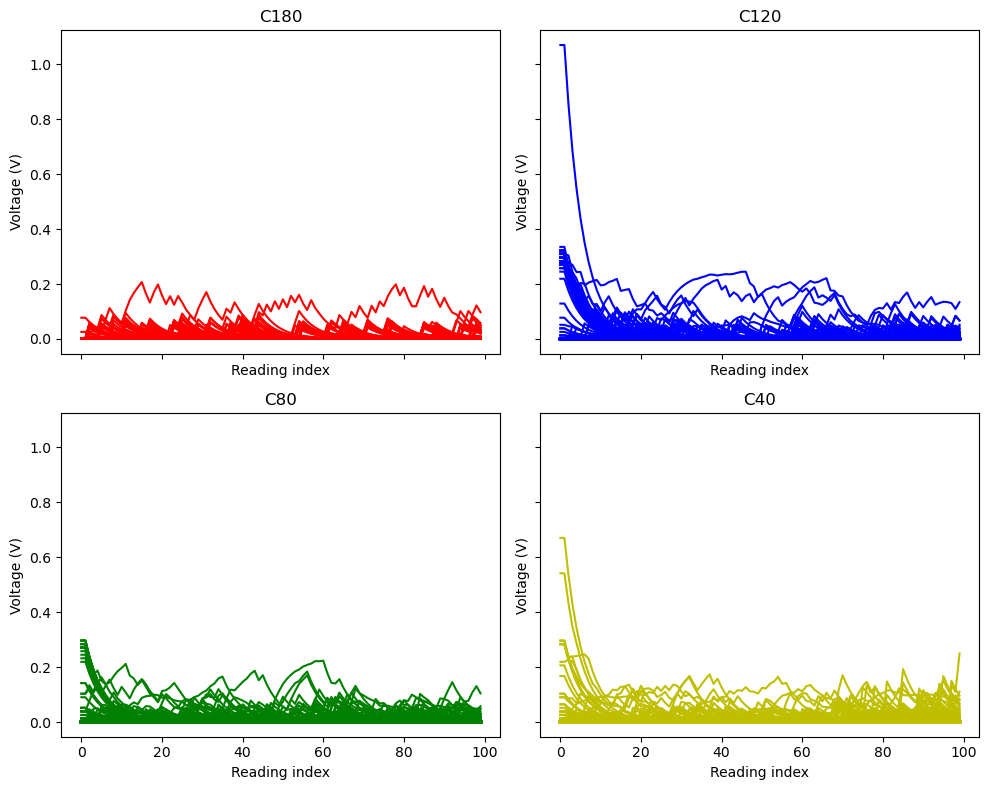

In [8]:
# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

# Plot data in each subplot
axs[0, 0].plot(low_pass_filter(d180[0:100]), 'r-')
axs[0, 0].set_title('C180')
axs[0, 0].set_ylabel('Voltage (V)')
axs[0, 0].set_xlabel('Reading index')

axs[0, 1].plot(low_pass_filter(d120.T[0:100]), 'b-')
axs[0, 1].set_title('C120')
axs[0, 1].set_ylabel('Voltage (V)')
axs[0, 1].set_xlabel('Reading index')

axs[1, 0].plot(low_pass_filter(d80.T[0:100]), 'g-')
axs[1, 0].set_title('C80')
axs[1, 0].set_ylabel('Voltage (V)')
axs[1, 0].set_xlabel('Reading index')

axs[1, 1].plot(low_pass_filter(d40.T[0:100]), 'y-')
axs[1, 1].set_title('C40')
axs[1, 1].set_ylabel('Voltage (V)')
axs[1, 1].set_xlabel('Reading index')
# Adjust layout
plt.tight_layout()
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/lowResVibrationAll.pdf")
# Show the plot
plt.show()

# Some modelling

In [359]:
cut_X=vibration_X[:,0:15]
#cut_X=X[:,0:5,:].reshape(len(X),5*13)
encoder = OneHotEncoder()  # sparse_output=False returns a dense array
# Fit and transform the label data
onehot_labels = encoder.fit_transform(y.reshape(-1, 1))
print(y[0],onehot_labels[0],y[401],onehot_labels[401],y[801],onehot_labels[801],y[-1],onehot_labels[0-1])
classes=np.argmax(onehot_labels,axis=1)
print(np.unique(classes, axis=0))
print(vibration_X.shape,classes.shape,X.shape)
X_train, X_test, y_train, y_test = train_test_split(cut_X, classes, test_size=0.2, random_state=42)
svm_model = SVC(decision_function_shape='ovo')

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
y_pred2 = svm_model.predict(X_train)
loss=np.abs(y_pred.reshape((y_pred.shape[0],1))-y_test)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Accuracy:",correct/len(loss))

loss=np.abs(y_pred.reshape((y_pred.shape[0],1))-y_test)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Accuracy:",correct/len(loss))

120   (0, 2)	1.0 180   (0, 3)	1.0 80   (0, 1)	1.0 40   (0, 0)	1.0
[[0]
 [1]
 [2]
 [3]]
(1600, 100) (1600, 1) (1600, 100, 13)
Accuracy: 0.36875
Accuracy: 0.36875


/its/home/drs25/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(4, 4) 320 320


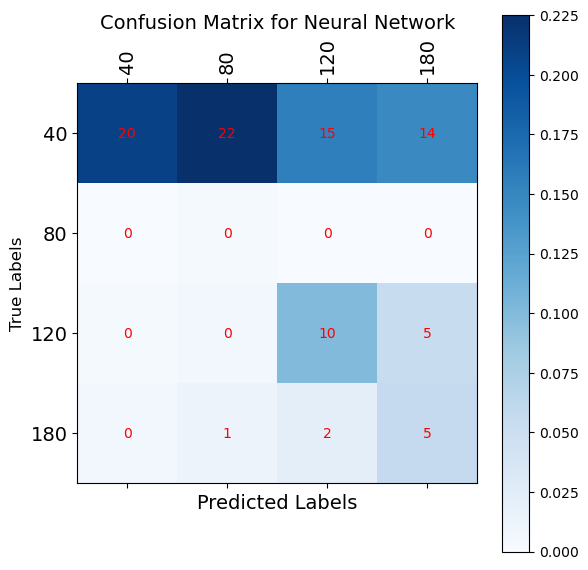

In [360]:
def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(y_train,axis=0)
    print(matrix.shape,len(true_labels),len(pred_labels))
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix/len(true_labels)

predictions = [y_pred]
model_names = ['Neural Network']
num_classes = len(np.unique(y_train,axis=0))
un=np.unique(y_train,axis=0)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(6, 6))
labels=["40","80","120","180"]
for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(y_pred, y_test, num_classes=len(np.unique(y_train,axis=0)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{int(value*100)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([labels[un[j][0]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([labels[un[j][0]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()

plt.show()